In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import math
from ngboost import NGBRegressor
from ngboost.distns import Normal
from gamma import Gamma

# Génération des données

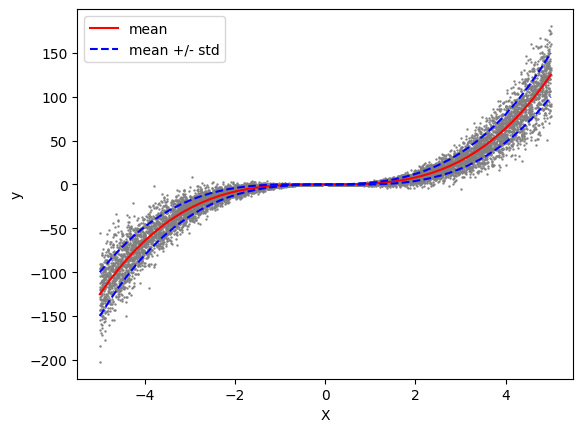

In [40]:
def distribution_normal(x) :
    µ = x**3
    sigma = x**2
    return µ, sigma

def generate_normal(distribution, n_samples, n_samples_test) :
    X = np.random.uniform(-5,5,n_samples)[...,None]
    y = np.array([[np.random.normal(*distribution(x[0]))] for x in X])

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    X_test = np.random.uniform(-5,5,n_samples_test)[...,None]
    y_test = np.array([[np.random.normal(*distribution(x[0]))] for x in X_test])

    y_train = y_train.T[0]
    y_val =y_val.T[0]
    y_test = y_test.T[0]


    plt.scatter(X,y,color='grey',s=0.5)
    plt.xlabel('X')
    plt.ylabel('y')
    mean = np.array([distribution(x)[0] for x in np.linspace(-5,5)])
    std = np.array([distribution(x)[1] for x in np.linspace(-5,5)])
    plt.plot(np.linspace(-5,5),mean,'r',label='mean')
    plt.plot(np.linspace(-5,5),mean+std,'--b',label='mean +/- std')
    plt.plot(np.linspace(-5,5),mean-std,'--b')
    plt.legend()

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = generate_normal(distribution_normal,10000,10000)

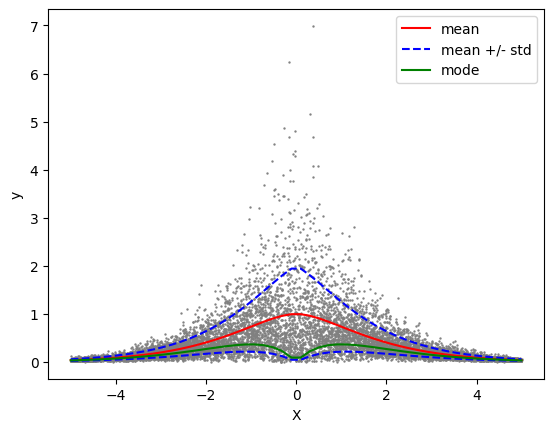

In [51]:
def distribution_gamma(x) :
    alpha = np.abs(x)+1
    beta = np.exp(np.abs(x))
    return alpha, beta



def generate_gamma(distribution, n_samples, n_samples_test) :
    X = np.random.uniform(-5,5,n_samples)[...,None]
    y = np.array([[np.random.gamma(distribution(x[0])[0],1/distribution(x[0])[1])] for x in X])

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    X_test = np.random.uniform(-5,5,n_samples_test)[...,None]
    y_test = np.array([[np.random.gamma(distribution(x[0])[0],1/distribution(x[0])[1])] for x in X_test])

    y_train = y_train.T[0]
    y_val =y_val.T[0]
    y_test = y_test.T[0]


    plt.scatter(X,y,color='grey',s=0.5)
    plt.xlabel('X')
    plt.ylabel('y')
    mean = np.array([distribution(x)[0]/distribution(x)[1] for x in np.linspace(-5,5)])
    var = np.array([distribution(x)[0]/(distribution(x)[1]**2) for x in np.linspace(-5,5)])
    mode = np.array([(distribution(x)[0]-1)/distribution(x)[1] for x in np.linspace(-5,5)])
    plt.plot(np.linspace(-5,5),mean,'r',label='mean')
    plt.plot(np.linspace(-5,5),mean+np.sqrt(var),'--b',label='mean +/- std')
    plt.plot(np.linspace(-5,5),mean-np.sqrt(var),'--b')
    plt.plot(np.linspace(-5,5),mode,'g',label='mode')
    plt.legend()

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = generate_gamma(distribution_gamma,10000,10000)

# Entraînement des modèles

In [52]:
def train_model(dist = Normal,max_depth=3,n_estimators=1000,natural_gradient=False,early_stopping_rounds=5) :
    tree = DecisionTreeRegressor(criterion='friedman_mse', max_depth=max_depth)
    model = NGBRegressor(Dist=dist,Base=tree,n_estimators=n_estimators, natural_gradient=natural_gradient)

    if early_stopping_rounds is not None :
        model.fit(X_train,y_train,
                  X_val=X_val,
                  Y_val=y_val,
                  early_stopping_rounds=early_stopping_rounds
                )
    else :
        model.fit(X_train,y_train,
                  X_val=X_val,
                  Y_val=y_val
                )
    
    return model

print('Natural Gradient :')
model_natural = train_model(dist=Gamma,natural_gradient=True)
print('\n')
print('Ordinary Gradient :')
model_ordinary = train_model(dist=Gamma,natural_gradient=False)

Natural Gradient :
[iter 0] loss=0.0567 val_loss=0.0392 scale=1.0000 norm=1.4406
[iter 100] loss=-0.3956 val_loss=-0.4017 scale=2.0000 norm=2.4191
[iter 200] loss=-0.5463 val_loss=-0.5498 scale=2.0000 norm=2.5298
[iter 300] loss=-0.6154 val_loss=-0.6169 scale=1.0000 norm=1.3128
[iter 400] loss=-0.6387 val_loss=-0.6398 scale=0.5000 norm=0.6738
[iter 500] loss=-0.6454 val_loss=-0.6455 scale=0.0005 norm=0.0007
[iter 600] loss=-0.6454 val_loss=-0.6455 scale=0.0005 norm=0.0007
[iter 700] loss=-0.6454 val_loss=-0.6455 scale=0.0005 norm=0.0007
[iter 800] loss=-0.6454 val_loss=-0.6455 scale=0.0005 norm=0.0007
[iter 900] loss=-0.6454 val_loss=-0.6455 scale=0.0005 norm=0.0007


Ordinary Gradient :
[iter 0] loss=0.0567 val_loss=0.0409 scale=0.5000 norm=0.6279
[iter 100] loss=-0.2399 val_loss=-0.2470 scale=2.0000 norm=1.7239
[iter 200] loss=-0.3860 val_loss=-0.3892 scale=4.0000 norm=3.9214
[iter 300] loss=-0.4970 val_loss=-0.4924 scale=2.0000 norm=2.3158
[iter 400] loss=-0.5580 val_loss=-0.5459 sc

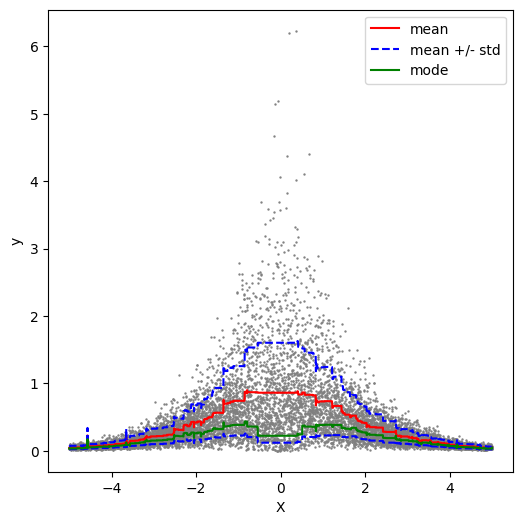

In [55]:
def plot_results_normal(X_test,y_test,model) :
    fig, ax = plt.subplots(figsize=(6,6))
    ax.scatter(X_test,y_test,color='grey',s=0.5)

    X_test = np.sort(X_test.T[0])[...,None]
    preds = model.pred_dist(X_test).params
    mean, std = preds['loc'],preds['scale']
    ax.plot(X_test,mean,'r', label = 'mean')
    ax.plot(X_test,mean+std,'--b',label='mean +/- std')
    ax.plot(X_test,mean-std,'--b')
    ax.set_xlabel('X')
    ax.set_ylabel('y')
    ax.legend()
    plt.show()

def plot_results_gamma(X_test,y_test,model) :
    fig, ax = plt.subplots(figsize=(6,6))
    ax.scatter(X_test.T[0],y_test,color='grey',s=0.5)

    X_test = np.sort(X_test.T[0])[...,None]
    preds = model.pred_dist(X_test).params
    mean, var, mode = preds['alpha']/preds['beta'], preds['alpha']/(preds['beta'])**2, (preds['alpha']-1)/preds['beta']
    ax.plot(X_test,mean,'r', label = 'mean')
    ax.plot(X_test,mean+np.sqrt(var),'--b',label='mean +/- std')
    ax.plot(X_test,mean-np.sqrt(var),'--b')
    ax.plot(X_test,mode,'g',label='mode')
    ax.set_xlabel('X')
    ax.set_ylabel('y')
    ax.legend()
    plt.show()

plot_results_gamma(X_test,y_test,model_natural)

# Calibration

In [56]:
def join_bins_recursive(separated_bins) :
    if len(separated_bins) == 1 :
        return np.array([[bin] for bin in separated_bins[0]])
    
    joint_bins = []
    for bin_0 in separated_bins[0] :
        for recursive_bin in join_bins_recursive(separated_bins[1:]) :
            joint_bins.append(np.vstack([np.array(bin_0),recursive_bin]))

    return np.array(joint_bins)

def cut_bins(predictions,frac_bins) :
    n_parameters = len(predictions[0])
    separated_bins = []
    for i in range(n_parameters) :
        sorted = np.sort(predictions[:,i])
        size = len(sorted)
        bin_size = int(frac_bins[i]*size)
        k = 0
        intervals_i = []
        while k+bin_size < size :
            intervals_i.append([sorted[k], sorted[k+bin_size]])
            k += bin_size
        intervals_i.append([sorted[k], sorted[-1]])
        separated_bins.append(intervals_i)
    
    return join_bins_recursive(separated_bins)



def select_X(X,predictions,bin) :
    inf, sup = bin[:,0], bin[:,1]
    mask = [k for k in range(len(predictions)) if ((inf <= predictions[k])*(predictions[k] < sup)).all()]
    return X[mask], mask



def group_X(X,predictions,frac_bins) :
    bins = cut_bins(predictions,frac_bins)
    X_grouped = []
    masks = []
    for bin in bins :
        selected, mask = select_X(X,predictions,bin)
        if len(selected) != 0 :
            X_grouped.append(selected)
            masks.append(mask)
    return X_grouped, masks



In [57]:
def estimate_params_normal(Y,masks) :
    µ = []
    σ = []
    for mask in masks :
        group = Y[mask]
        n = len(group)
        µ.append(np.mean(group))
        if n > 1 :
            σ.append(np.sqrt( (n/(n-1)) * np.var(group)))
        else :
            σ.append(0)
    µ = np.array(µ)
    σ = np.array(σ)
    return np.stack([µ,σ]).T


def estimate_params_gamma(Y,masks) :
    alpha = []
    beta = []
    for mask in masks :
        group = Y[mask]
        n = len(group)
        mean = np.mean(group)
        var = np.var(group)
        if n>1 :
            var = (n/(n-1)) * var
        alpha.append((mean**2)/var)
        beta.append(mean/var)
    alpha = np.array(alpha)
    beta = np.array(beta)
    return np.stack([alpha,beta]).T


In [58]:
def calibration(X,y,model,estimator,frac_bins,plot=False) :
    pred_params = model.pred_dist(X).params
    predictions = np.stack([pred_params[list(pred_params.keys())[0]], pred_params[list(pred_params.keys())[1]]]).T
    _, masks = group_X(X,predictions,frac_bins)
    prediction_bins = []
    for mask in masks :
        µ = predictions[mask][:,0].mean()
        σ = predictions[mask][:,1].mean()
        prediction_bins.append([µ,σ])
    model = np.array(prediction_bins)
    estimate = estimator(y,masks)

    if plot :
        fig, ax = plt.subplots(figsize=(6,6))
        ax.scatter(model[:,0],model[:,1],color='r',label='Average model prediction in each bin')
        ax.scatter(estimate[:,0],estimate[:,1],color='b',label='Estimated parameters in each bin')
        ax.set_xlabel(f'{list(pred_params.keys())[0]}')
        ax.set_ylabel(f'{list(pred_params.keys())[1]}')
        ax.grid()
        ax.legend()
        ax.set_title('Calibration of the model')

    return model, estimate

C:\Users\natha\AppData\Local\Temp\ipykernel_18524\695280128.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  alpha.append((mean**2)/var)
C:\Users\natha\AppData\Local\Temp\ipykernel_18524\695280128.py:28: RuntimeWarning: divide by zero encountered in scalar divide
  beta.append(mean/var)


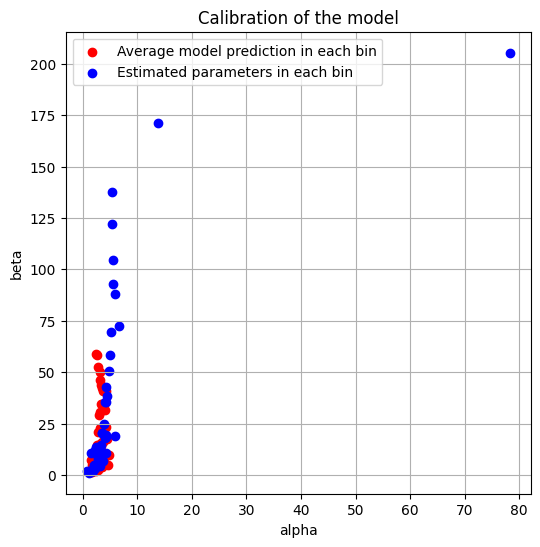

In [59]:
prediction, estimate = calibration(X_test,y_test,model_ordinary,estimate_params_gamma,[0.1,0.1],True)

x_pred = prediction[:,0]
y_pred = prediction[:,1]
x_obj = estimate[:,0]
y_obj = estimate[:,1]

# Questionnement sur les estimateurs

C:\Users\natha\AppData\Local\Temp\ipykernel_18524\695280128.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  alpha.append((mean**2)/var)
C:\Users\natha\AppData\Local\Temp\ipykernel_18524\695280128.py:28: RuntimeWarning: divide by zero encountered in scalar divide
  beta.append(mean/var)


array([[  5.99909148, 148.27838412],
       [  5.99881749, 148.23776255],
       [  5.99792577, 148.10563537],
       ...,
       [  5.99857272, 148.20148312],
       [  5.9985975 , 148.20515496],
       [  5.99969926, 148.3685321 ]])

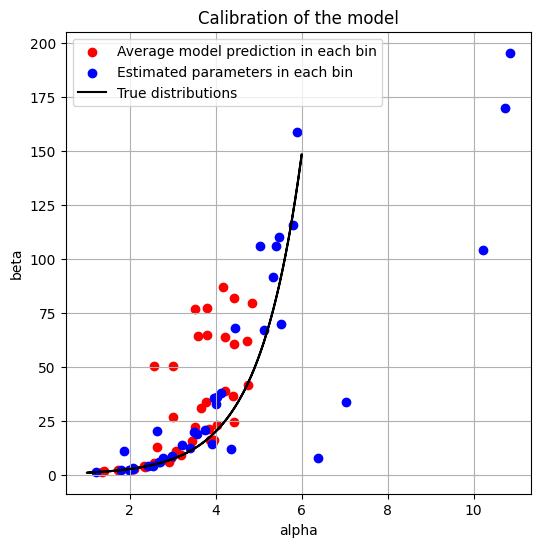

In [60]:
def compare_to_distrib(X,y,model,estimator,true_distrib,frac_bins, plot=True) :
    pred_params = model.pred_dist(X).params
    predictions = np.stack([pred_params[list(pred_params.keys())[0]], pred_params[list(pred_params.keys())[1]]]).T
    _, masks = group_X(X,predictions,frac_bins)
    prediction_bins = []
    for mask in masks :
        µ = predictions[mask][:,0].mean()
        σ = predictions[mask][:,1].mean()
        prediction_bins.append([µ,σ])
    model = np.array(prediction_bins)
    estimate = estimator(y,masks)
    distrib = np.array([true_distrib(x) for x in np.sort(X.T[0])])

    if plot :
        fig, ax = plt.subplots(figsize=(6,6))
        ax.scatter(model[:,0],model[:,1],color='r',label='Average model prediction in each bin')
        ax.scatter(estimate[:,0],estimate[:,1],color='b',label='Estimated parameters in each bin')
        ax.plot(distrib[:,0],distrib[:,1],color='black',label='True distributions')
        ax.set_xlabel(f'{list(pred_params.keys())[0]}')
        ax.set_ylabel(f'{list(pred_params.keys())[1]}')
        ax.grid()
        ax.legend()
        ax.set_title('Calibration of the model')

    return distrib


compare_to_distrib(X_test,y_test,model_natural,estimate_params_gamma,distribution_gamma,[0.1,0.1])

# Calibration : Vue Dynamique

In [ ]:
%matplotlib widget
import matplotlib.animation as animation
from matplotlib import cm


fig, ax = plt.subplots()
ax.grid()
ax.set_title('Calibration of the model : Dynamic View')

min_x = min(x_pred.min(),x_obj.min())
max_x = max(x_pred.max(),x_obj.max())
delta_x = (max_x - min_x)/10

min_y = min(y_pred.min(),y_obj.min())
max_y = max(y_pred.max(),y_obj.max())
delta_y = (max_y - min_y)/10

scat = ax.scatter(x_pred, y_pred, s=5,color='red')

ax.set(xlim=[min_x - delta_x, max_x + delta_x], ylim=[min_y - delta_y, max_y + delta_y], xlabel='Param 1', ylabel='Param 2')

def update(frame):
    t = frame/10
    # for each frame, update the data stored on each artist.
    x = x_pred*(1-t) + x_obj*t
    y = y_pred*(1-t) + y_obj*t
    data = np.stack([x, y]).T
    scat.set_offsets(data)
    return (scat)
    
anim = animation.FuncAnimation(fig=fig, func=update, frames=10,repeat=False)
plt.show()